# Causal Machine Learning with EconML

In [3]:
!pip install econml

## Paper
Brantner, C. L., Nguyen, T. Q., Parikh, H., Zhao, C., Hong, H., & Stuart, E. A. (2025). Precision Mental Health: Predicting Heterogeneous Treatment Effects for Depression through Data Integration. arXiv preprint arXiv:2509.04604.

https://arxiv.org/pdf/2509.04604

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import plotly.express as px

# -------------------------------
# Generate synthetic data
# -------------------------------
np.random.seed(42)
n = 2000

# Descriptive statistics for Duke EHR sample
age_mean, age_sd = 44.8, 12.7
weight_mean, weight_sd = 201, 58.5
female_prob = 0.754
diabetes_prob = 0.207
hypothyroidism_prob = 0.111
anxiety_prob = 0.610
antidepressant_prob = 0.582
thyroid_med_prob = 0.093
severe_depression_prob = 0.268

# Generate synthetic features
age = np.random.normal(age_mean, age_sd, n).clip(18, 75)
weight = np.random.normal(weight_mean, weight_sd, n).clip(90, 350)
female = np.random.binomial(1, female_prob, n)
diabetes = np.random.binomial(1, diabetes_prob, n)
hypothyroidism = np.random.binomial(1, hypothyroidism_prob, n)
anxiety = np.random.binomial(1, anxiety_prob, n)
antidepressant = np.random.binomial(1, antidepressant_prob, n)
thyroid_med = np.random.binomial(1, thyroid_med_prob, n)
severe_depression = np.random.binomial(1, severe_depression_prob, n)

# Treatment assignment: duloxetine (0) or vortioxetine (1)
treatment = np.random.binomial(1, 0.5, n)

# Simulate outcome: change in MADRS score
baseline_madrs = np.where(severe_depression == 1, 30, 22)
true_effect = 2.0 * treatment + np.random.normal(0, 1, n)
outcome = (baseline_madrs - (baseline_madrs - 8 - true_effect))

# Create DataFrame
data = pd.DataFrame({
    'Age': age,
    'Weight': weight,
    'Female': female,
    'Diabetes': diabetes,
    'Hypothyroidism': hypothyroidism,
    'Anxiety': anxiety,
    'Antidepressant': antidepressant,
    'Thyroid_Med': thyroid_med,
    'Severe_Depression': severe_depression,
    'Treatment': treatment,
    'MADRS_Change': outcome
})
data.head()

,Age,Weight,Female,Diabetes,Hypothyroidism,Anxiety,Antidepressant,Thyroid_Med,Severe_Depression,Treatment,MADRS_Change
0,51.108270,161.502071,1,0,0,1,1,0,0,0,8.747995
1,43.044043,192.545658,1,0,0,1,1,0,0,0,6.771221
2,53.025644,154.643435,0,0,0,1,0,1,0,0,7.901127
3,64.142479,182.984251,1,0,0,1,0,0,0,1,9.314065
4,41.826252,90.223542,1,0,0,1,0,0,0,1,10.473341


In [18]:
# -------------------------------
# Split data into training/testing
# -------------------------------
train, test = train_test_split(data, test_size=0.3, random_state=42)
X_train = train.drop(columns=['MADRS_Change'])
y_train = train['MADRS_Change']
X_test = test.drop(columns=['MADRS_Change'])
y_test = test['MADRS_Change']

In [19]:
# -------------------------------
# S-Learner: Single model with treatment as a feature
# -------------------------------
X_train_S = X_train.copy()
X_test_S = X_test.copy()
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_S, y_train)
pred_S_treated = model.predict(X_test_S.assign(Treatment=1))
pred_S_control = model.predict(X_test_S.assign(Treatment=0))
CATE_S = pred_S_treated - pred_S_control

In [20]:
# -------------------------------
# T-Learner: Separate models for treated and control
# -------------------------------
model_treated = RandomForestRegressor(n_estimators=100, random_state=42)
model_control = RandomForestRegressor(n_estimators=100, random_state=42)

model_treated.fit(X_train[X_train['Treatment']==1].drop(columns=['Treatment']), y_train[X_train['Treatment']==1])
model_control.fit(X_train[X_train['Treatment']==0].drop(columns=['Treatment']), y_train[X_train['Treatment']==0])

pred_T_treated = model_treated.predict(X_test.drop(columns=['Treatment']))
pred_T_control = model_control.predict(X_test.drop(columns=['Treatment']))
CATE_T = pred_T_treated - pred_T_control

In [39]:
# -------------------------------
# X-Learner: Use T-Learner predictions to compute imputed treatment effects
# -------------------------------
D1 = y_train[X_train['Treatment']==1] - model_control.predict(X_train[X_train['Treatment']==1].drop(columns=['Treatment']))
D0 = model_treated.predict(X_train[X_train['Treatment']==0].drop(columns=['Treatment'])) - y_train[X_train['Treatment']==0]

model_D1 = RandomForestRegressor(n_estimators=100, random_state=42)
model_D0 = RandomForestRegressor(n_estimators=100, random_state=42)
model_D1.fit(X_train[X_train['Treatment']==1].drop(columns=['Treatment']), D1)
model_D0.fit(X_train[X_train['Treatment']==0].drop(columns=['Treatment']), D0)

CATE_X = 0.5*(model_D1.predict(X_test.drop(columns=['Treatment']))) + 0.5*(model_D0.predict(X_test.drop(columns=['Treatment'])))

# Rank by X-Learner predicted CATE
test = test.copy()
test['CATE_X'] = CATE_X
ranked = test.sort_values(by='CATE_X', ascending=False).head(10)
print("Top 10 patients ranked by predicted CATE (X-Learner):")
print(ranked[['Age','Weight','Female','Treatment','CATE_X']])

Top 10 patients ranked by predicted CATE (X-Learner):
            Age      Weight  Female  Treatment    CATE_X
305   46.290058  350.000000       1          1  3.328495
1233  75.000000  312.818017       1          1  3.288776
120   54.846106  342.138002       0          1  3.240937
1592  50.344310  335.762867       0          1  3.171303
506   37.276597  350.000000       0          0  3.149367
614   75.000000  236.029472       1          0  3.111962
1686  38.899360  346.383610       0          1  3.042380
218   38.635883  323.833725       1          1  3.001375
1013  36.047315  119.268586       1          1  2.996424
1319  42.425464  336.722382       1          0  2.982484


In [26]:
true_effect_coef = 2.0
# Compute mean and standard deviation for each learner's CATE estimates
mean_S, std_S = np.mean(CATE_S), np.std(CATE_S)
mean_T, std_T = np.mean(CATE_T), np.std(CATE_T)
mean_X, std_X = np.mean(CATE_X), np.std(CATE_X)

print("True treatment effect parameter:", true_effect_coef)
print("\nS-Learner: mean = {:.3f}, std = {:.3f}".format(mean_S, std_S))
print("T-Learner: mean = {:.3f}, std = {:.3f}".format(mean_T, std_T))
print("X-Learner: mean = {:.3f}, std = {:.3f}".format(mean_X, std_X))

True treatment effect parameter: 2.0

S-Learner: mean = 1.961, std = 0.526
T-Learner: mean = 1.960, std = 0.517
X-Learner: mean = 1.954, std = 0.408


### Plot the X-Learner CATE Distribution

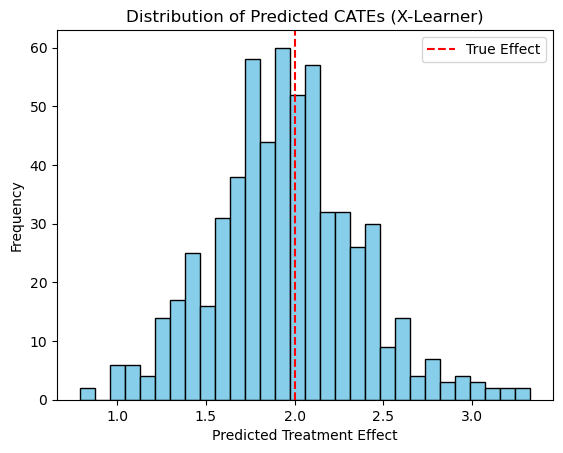

In [6]:
plt.hist(CATE_X, bins=30, color='skyblue', edgecolor='black')
plt.axvline(2.0, color='red', linestyle='--', label='True Effect')
plt.title('Distribution of Predicted CATEs (X-Learner)')
plt.xlabel('Predicted Treatment Effect')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Feature Importance for the X-Learner CATE Drivers

Use SHAP values or permutation importance on the X-Learner models to see which covariates drive heterogeneity.

/var/folders/b8/hq7p21n142n321y966q8j1600000gn/T/ipykernel_1111/2069221965.py:4: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



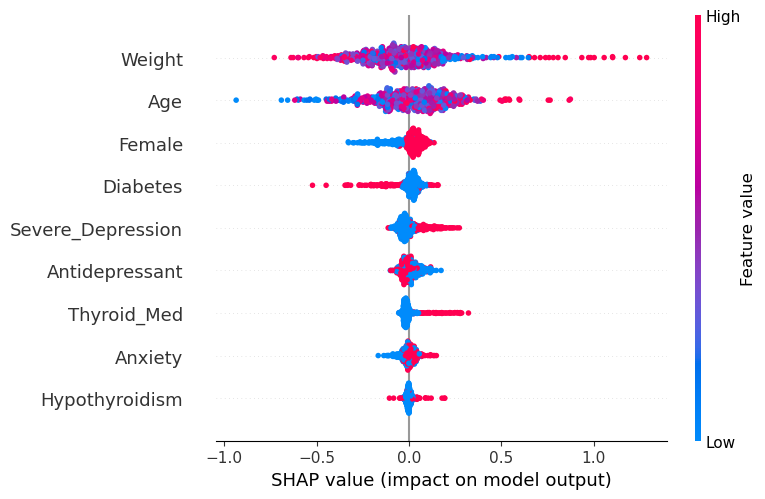

In [7]:
import shap
explainer = shap.TreeExplainer(model_D1)  # or model_D0
shap_values = explainer.shap_values(X_test.drop(columns=['Treatment']))
shap.summary_plot(shap_values, X_test.drop(columns=['Treatment']))

### Model Prediction in Action
Sort patients by predicted CATE and display top/bottom 10 for targeting interventions.

In [9]:
# Sort patients by predicted CATE (X-Learner)
ranked = test.sort_values(by='CATE_X', ascending=False)

# Top 10 patients (highest predicted benefit from treatment)
top_10 = ranked.head(10)

# Bottom 10 patients (lowest predicted benefit)
bottom_10 = ranked.tail(10)

# Display tables
print("Top 10 patients ranked by predicted CATE (X-Learner):")
print(top_10[['Age', 'Weight', 'Female', 'Treatment', 'CATE_X']])

print("\nBottom 10 patients ranked by predicted CATE (X-Learner):")
print(bottom_10[['Age', 'Weight', 'Female', 'Treatment', 'CATE_X']])


Top 10 patients ranked by predicted CATE (X-Learner):
            Age      Weight  Female  Treatment    CATE_X
305   46.290058  350.000000       1          1  3.328495
1233  75.000000  312.818017       1          1  3.288776
120   54.846106  342.138002       0          1  3.240937
1592  50.344310  335.762867       0          1  3.171303
506   37.276597  350.000000       0          0  3.149367
614   75.000000  236.029472       1          0  3.111962
1686  38.899360  346.383610       0          1  3.042380
218   38.635883  323.833725       1          1  3.001375
1013  36.047315  119.268586       1          1  2.996424
1319  42.425464  336.722382       1          0  2.982484

Bottom 10 patients ranked by predicted CATE (X-Learner):
            Age      Weight  Female  Treatment    CATE_X
694   52.332386  220.530808       1          0  1.097381
888   52.301316  178.476224       1          1  1.059882
1006  56.168954  229.433123       1          1  1.039339
1487  22.437728  239.898239      